# <center>M2 MIND -   ADL</center>
##  <center>  Generative Adversarial Networks  </center>

Ce TME a pour objectif d'expérimenter les Generative Adversarial Networks
(GANs) sur un problème de génération de visages.

De manière classique, un GAN se formule selon un problème adverse de la
manière suivante: $$\min\limits_{G} \max\limits_D V(D,G) = \mathbb{E}_{x\sim
p_{data}(x)}\big[logD(x)\big] + \mathbb{E}_{z\sim
p_{z}(z)}\big[log(1-D(G(z)))\big]$$ Cette formulation met en jeu deux réseaux
adverse:
*   Un réseau discriminateur $D$, dont l'objectif est de savoir distinguer les
    données réelles des données simulées
*   Un réseau générateur $G$, dont l'objectif est de flouer le discriminateur

À l'optimum, avec des réseaux de capacité infinie, la distribution $p_G$ des
données générées par $G$ est prouvée suivre la distribution des données
réelles $p_{data}$. Bien sûr nous ne travaillons pas avec des réseaux de
capacité infinie (et d'ailleurs heureusement car on ne veut pas apprendre par
coeur les données d'apprentissage), mais l'objectif est d'approcher cette
distribution $p_{data}$ en apprenant un générateur neuronal dont les sorties
sont difficilement distinguables des vraies données pour le discriminateur.

Nous proposons de mettre ce genre d'architecture pour un la génération de
visages: selon un ensemble de visages d'entraînement, il s'agit d'apprendre à
générer des visages qui paraissent les plus réalistes possibles tout en
conservant une certaine diversité dans les distributions de sortie. Pour cela
nous emploierons une architecture DCGAN, qui utilise des réseaux de neurones
convolutionnels (CNNs) pour le générateur et le discriminateur.

In [1]:
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import torch.utils.data
import torchvision.datasets as dset
import torchvision.utils as vutils
import torch.backends.cudnn as cudnn
from torchvision import datasets

import os

In [2]:
cache_dir = os.environ.get(
    "TORCHVISION_CACHE", os.path.expanduser("~/.cache/torchvision")
)
cache_dir

'/home/marilynch/.cache/torchvision'

In [3]:
#!pip install gdown

Le code ci-dessous permet de déclarer la manière de charger les données.

Lorsque des données sont demandées (pour la construction d'un nouveau batch
par exemple), une série de transformations est appliquée sur les images, selon
la composition de transformateurs déclarée pour le chargement:
*    redimentionnement des images en 64 par 64
*    recadrage au centre (qui ne fait rien ici car image déjà dans la taille
     du cadre mais si utile pour d'autres paramètres)
*    conversion en tenseur pytorch
*    normalisation des valeurs RGB selon une moyenne de 0.5 et un ecart-type
     de 0.5.

In [4]:
"""
image_size = 64
dataset = dset.CelebA(
    root=cache_dir,
    transform=transforms.Compose(
        [
            transforms.Resize(image_size),
            transforms.CenterCrop(image_size),
            transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
        ]
    ),
    download=True,
)

print(dataset)
"""

'\nimage_size = 64\ndataset = dset.CelebA(\n    root=cache_dir,\n    transform=transforms.Compose(\n        [\n            transforms.Resize(image_size),\n            transforms.CenterCrop(image_size),\n            transforms.ToTensor(),\n            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),\n        ]\n    ),\n    download=True,\n)\n\nprint(dataset)\n'

In [5]:
# get MNIST

train_MNIST = datasets.MNIST(
    root="data",
    train=True,
    download=True,
    transform=transforms.ToTensor()
)

train_MNIST = datasets.MNIST(
    root="data",
    train=False,
    download=True,
    transform=transforms.ToTensor()
)

In [6]:
# get CIFAR10

transform = transforms.ToTensor()

train_CIFAR = datasets.CIFAR10(
    root="data",
    train=True,
    download=True,
    transform=transform
)

test_CIFAR = datasets.CIFAR10(
    root="data",
    train=False,
    download=True,
    transform=transform
)

Files already downloaded and verified
Files already downloaded and verified


In [7]:
print(train_CIFAR)

Dataset CIFAR10
    Number of datapoints: 50000
    Root location: data
    Split: Train
    StandardTransform
Transform: ToTensor()


In [8]:
# picking one CIFAR class to work on so the data isn't too diverse

# class 3 == cats

label_name = train_CIFAR.classes[3]

train_CIFAR_cat = []

for i in range(len(train_CIFAR)):
    if (train_CIFAR[i][1] == 3):
        train_CIFAR_cat.append(train_CIFAR[i]) 

for i in range(len(test_CIFAR)):
    if (test_CIFAR[i][1] == 3):
        train_CIFAR_cat.append(test_CIFAR[i]) 

In [9]:
print(len(train_CIFAR_cat))

6000


Le code ci-dessous permet de déclarer la manière de charger les images et en
affiche un échantillon.

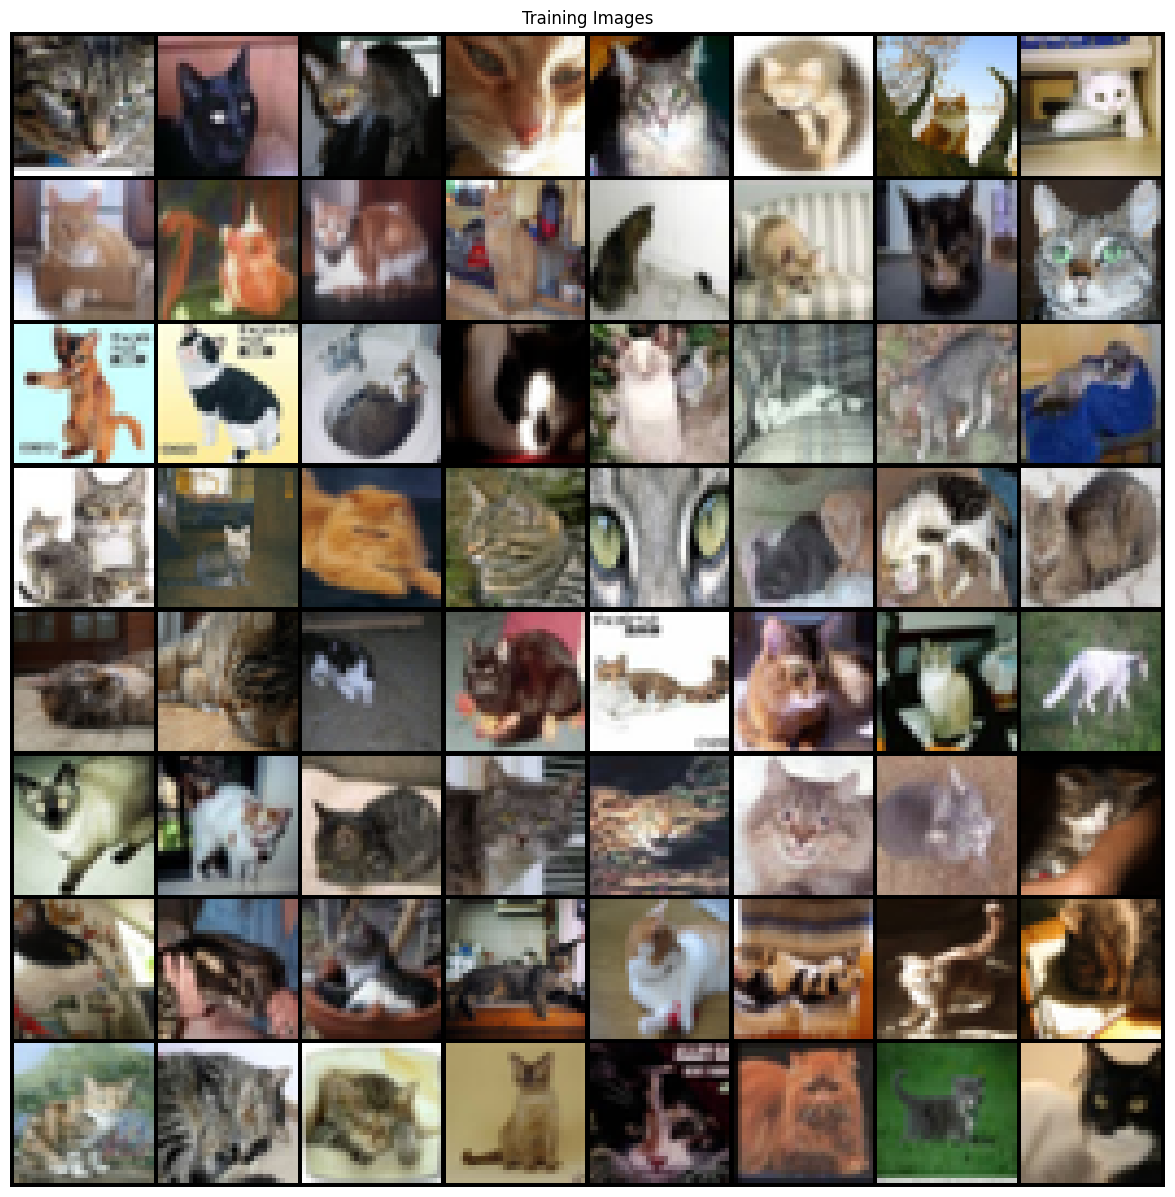

In [41]:
import matplotlib.pyplot as plt
import os


seed = 0
torch.manual_seed(seed)
np.random.seed(seed)

batch_size = 128
workers = 2

dataloader = torch.utils.data.DataLoader(
    train_CIFAR_cat, batch_size=batch_size, shuffle=True, num_workers=workers
)

# Affichage de quelques images
real_batch = next(
    iter(dataloader)
)  # real_batch est une liste de 2 tenseurs où le 1er correspond aux images, les second correspond aux labels (ici 0 partout)

plt.figure(figsize=(15, 15))
plt.axis("off")
plt.title("Training Images")
plt.imshow(
    np.transpose(
        vutils.make_grid(
            real_batch[0][:64], padding=1, normalize=True
        ),
        (1, 2, 0),
    )
)

Le réseau $D$ est un empilement de couches de convolution 2D avec batchNorm2D
et activations RELU:

In [22]:
# Nombre de canaux de l'entrée
nc = 3

# Facteur du nombre de canaux de sortie des différentes couches de convolution
ndf = 64


# Initialisation recommandee pour netG et netD dans DCGAN
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find("Conv") != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find("BatchNorm") != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)


class Discriminator(nn.Module):
    """Outputs a logit"""
    def __init__(self):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            # input is (nc) x 32 x 32
            
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf) x 32 x 32
            
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*2) x 16 x 16
            
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*4) x 8 x 8
            
            nn.Conv2d(ndf * 4, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
            # classification
            
            # nn.BatchNorm2d(ndf * 8),
            # nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*8) x 4 x 4
            # nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),
        )

    def forward(self, input):
        return self.main(input)


netD = Discriminator()
netD.apply(weights_init)
print(netD)

Discriminator(
  (main): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (9): Sigmoid()
  )
)


In [25]:
nz = 100  # Taille du vecteur z donné en entrée du générateur
ngf = (
    64  # Facteur du nombre de canaux de sortie des différentes couches de déconvolution
)

# in_channels, out_channels, kernel_size, stride=1, padding=0

class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d(nz, ngf * 4, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # state size. (ngf*8) x 4 x 4
            nn.ConvTranspose2d(ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # state size. (ngf*4) x 8 x 8
            nn.ConvTranspose2d(ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            # state size. (ngf*2) x 16 x 16
            nn.ConvTranspose2d(ngf, nc, 4, 2, 1, bias=False),
            # nn.BatchNorm2d(ngf),
            # nn.ReLU(True),
            # state size. (ngf) x 32 x 32
            # nn.ConvTranspose2d(ngf, nc, 4, 2, 1, bias=False),
            nn.Tanh()
            # state size. (nc) x 64 x 64
        )

    def forward(self, input):
        return self.main(input)


netG = Generator()
netG.apply(weights_init)
print(netG)

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 256, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): Tanh()
  )
)


Donner la procédure d'entraînement de ces deux réseaux. L'optimisation se fera
ADAM selon les deux coûts adverses du discriminateur et du générateur. Pour
chaque nouveau batch d'images, on alterne les deux mises à jour suivantes,
selon un batch de vecteurs $z$ tirés aléatoirement selon une loi normale
centrée réduite (un nouveau batch de $z$ à chaque itération):

1.   Un pas de gradient sur les paramètres du réseau D pour maximiser:
     $log(D(x)) + log(1 - D(G(z)))$
2.   Un pas de gradient sur les paramètres du réseau G pour maximiser : $log(D(G(z)))$. 
   - **Question :** pourquoi ne pas minimiser $log(1-D(G(z)))$ comme la formulation initiale le suggère ?


Afin de suivre l'évolution de l'apprentissage, on pourra logguer l'erreur du
discriminateur relevée en 1, l'erreur du générateur relevée en 2, la moyenne
des sorties du discriminateur sur les images réelles et la moyenne des sorties
du discriminateur sur les images générées.

À la fin de chaque époque (i.e., lorsque l'on a itéré sur tous les batchs du
DataLoader), on pourra enregistrer les images générées à partir d'un batch de
vecteurs $z$ fixe dans le Google Drive pour observer l'évolution des capacités
du générateur.

**Réponse :** <br>
- Minimiser log(1 - D(G(z))), soit minimiser 1 - D(G(z)), correspond à maximiser D(G(z)).
- Dans ce cas, le seul but du générateur serait de tromper le discriminateur, et une solution optimal pourrait être de générer des images aléaltoires.
- Or, on a besoin que les images générées par le générateur soient aussi similaires aux données d'entrainement.
- Pour cela, on a besoin d'ajouter un pas de gradient qui a pour but de maximiser la performance du discriminateur. On ajoute alors la maximisation sur log(D(x)) pour 'récompenser' le discriminateur quand il prédit qu'une image réelle (x) est réelle;
- -> max D(x) pour D(x) == 1 -> classification 'réelle' d'une image réelle
-  et log(1 - D(G(z))) pour 'récompenser' le discriminateur quand il prédit qu'une fausse image (D(G(z))) est fausse;
-  -> max 1 - D(G(z)) pour D(G(z)) == 0 -> classification 'fausse' d'une fausse image

In [38]:
# Implémenter la boucle d'apprentissage

num_epochs = 200

criterion = nn.BCELoss()
optimizerG = torch.optim.Adam(netG.parameters(), lr = 0.002)
optimizerD = torch.optim.Adam(netD.parameters(), lr = 0.002)

real_label = 1.0
fake_label = 0.0

for epoch in range(num_epochs):
    for i, data in enumerate(dataloader):

        # Discriminator step
        netD.zero_grad()

        # Train with real images: log(D(x))
        real_images = data[0]
        b_size = real_images.size(0)

        labels = torch.full((b_size,), real_label)
        output = netD(real_images).view(-1)

        lossD_real = criterion(output, labels)
        lossD_real.backward()

        # Train with fake images: log(1-D(G(z)))
        noise = torch.randn(b_size, nz, 1, 1)
        fake_images = netG(noise)

        labels.fill_(fake_label)
        output = netD(fake_images.detach())
        output = output.squeeze(1, 2, 3)

        lossD_fake = criterion(output, labels)
        lossD_fake.backward()

        lossD = lossD_real + lossD_fake
        optimizerD.step()


        # Generator step: log(D(G(z))
        netG.zero_grad()

        labels.fill_(real_label)
        output = netD(fake_images).view(-1)

        lossG = criterion(output, labels)
        lossG.backward()
        optimizerG.step()

        if i % 100 == 0:
            print(f"[{epoch}/{num_epochs}][{i}/{len(dataloader)}] "
                  f"Loss_D: {lossD.item():.4f} "
                  f"Loss_G: {lossG.item():.4f}")


[0/200][0/47] Loss_D: 0.3917 Loss_G: 0.0208
[1/200][0/47] Loss_D: 0.4008 Loss_G: 5.9574
[2/200][0/47] Loss_D: 0.1531 Loss_G: 11.1074
[3/200][0/47] Loss_D: 0.1326 Loss_G: 4.9776
[4/200][0/47] Loss_D: 0.6244 Loss_G: 5.3561
[5/200][0/47] Loss_D: 0.4148 Loss_G: 5.3273
[6/200][0/47] Loss_D: 0.0566 Loss_G: 7.9718
[7/200][0/47] Loss_D: 0.0190 Loss_G: 7.9642
[8/200][0/47] Loss_D: 0.2291 Loss_G: 5.9286
[9/200][0/47] Loss_D: 0.0774 Loss_G: 5.4918
[10/200][0/47] Loss_D: 0.3905 Loss_G: 4.4629
[11/200][0/47] Loss_D: 0.2118 Loss_G: 4.0878
[12/200][0/47] Loss_D: 0.7880 Loss_G: 1.7362
[13/200][0/47] Loss_D: 0.2123 Loss_G: 6.0941
[14/200][0/47] Loss_D: 0.0819 Loss_G: 5.3193
[15/200][0/47] Loss_D: 0.0292 Loss_G: 6.6522
[16/200][0/47] Loss_D: 0.1593 Loss_G: 5.5589
[17/200][0/47] Loss_D: 1.2960 Loss_G: 7.9824
[18/200][0/47] Loss_D: 0.7312 Loss_G: 4.3179
[19/200][0/47] Loss_D: 0.0417 Loss_G: 7.2640
[20/200][0/47] Loss_D: 0.2925 Loss_G: 4.5733
[21/200][0/47] Loss_D: 0.0513 Loss_G: 10.3745
[22/200][0/47] Los

Le code ci-dessous applique votre réseau à un
batch de $z$ aléatoires et affiche les images générées (et enregistre dans
fake.png).

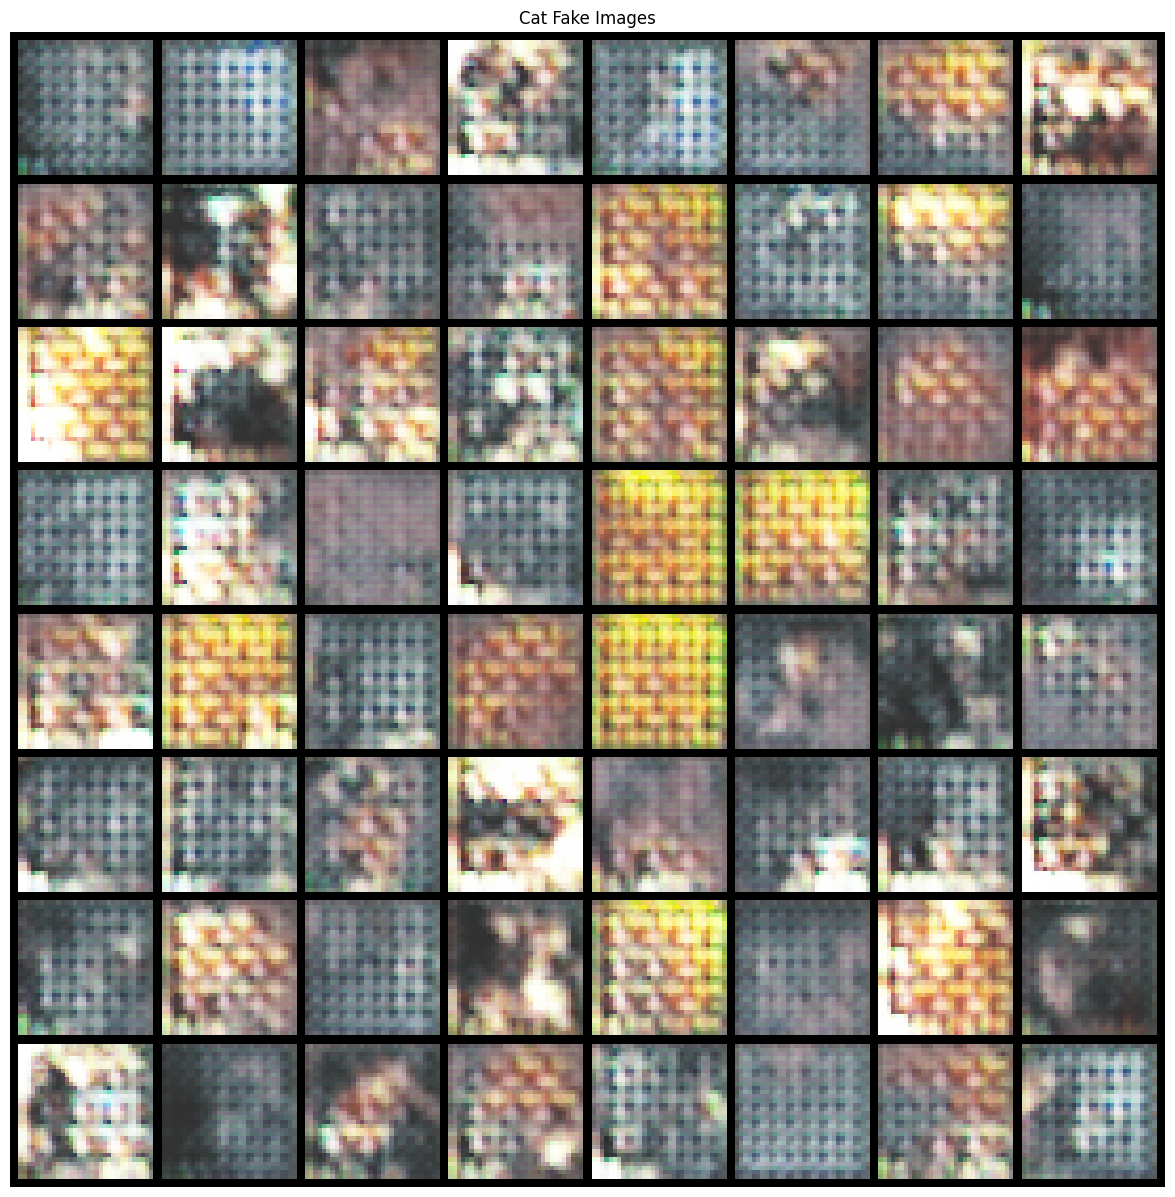

In [40]:
img_list = []
noise = torch.randn(64, nz, 1, 1)
with torch.no_grad():
    netG.eval()
    fake = netG(noise).detach()
img = vutils.make_grid(fake, padding=2, normalize=True)
img_list.append(img)
plt.figure(figsize=(15, 15))
plt.axis("off")
plt.title("Cat Fake Images")
plt.imshow(np.transpose(img, (1, 2, 0)))
plt.savefig("fake.png")

# DCGANs

Le générateur du papier original DCGAN possède en fait l'architecture
suivante:

![Generator](https://pytorch.org/tutorials/_images/dcgan_generator.png)

Comme le réseau $G$ définit plus haut, il correspond à un empilement de
couches de convolutions transposées (appelée dans certains papiers couches de
déconvolution). Contrairement aux convolutions classiques qui mènent à une
réduction de la taille des sorties, les convolutions transposées agrandissent
les cartes de caractéristiques considérées (feature maps). C'est
particulièrement adapté pour de la génération d'images à partir d'un code de
petite taille (ici $z$).

 Pour comprendre comment fonctionne la convolution transposée, voici un
 exemple simple avec une entrée 2 x 2 et un noyau 2 x 2. Chaque élément de
 l'entrée (4 éléments) est multiplié par le noyau et le résultat est ajouté à
 la sorte de taille 3 x 3:

![BasicTransposeConv2D](https://d2l.ai/_images/trans_conv.svg)

Et voici deux animations pour se représenter l'opération d'une manière plus
générale. A gauche on utilise un stride de 1, à droite un stride de 2:

<p align="center">
<img src="https://i.stack.imgur.com/YyCu2.gif">
<img src="https://i.stack.imgur.com/f2RiP.gif">
</p>


Suivant la doc Pytorch de torch.nn.ConvTranspose2d, la hauteur $H_{out}$ et la
largeur $W_{out}$ des cartes de sortie du ConvTranspose2d peuvent se calculer
de la manière suivante:

$H_{out}$=($H_{in}$−1)×stride−2×padding+dilation×(kernel_size−1)+output_padding+1

$W_{out}$=($W_{in}$−1)×stride−2×padding+dilation×(kernel_size−1)+output_padding+1


Proposer un nouveau réseau $G$ qui respecte l'architecture du schéma du papier
DCGAN et comparer les résultats. On gardera le paramètre de dilation à sa
valeur de 1 par défaut mais il est possible de moduler les valeurs de padding
et output_padding pour obtenir des sorties de la taille désirée.

# Pour aller plus loin...

- [Non-Saturating GAN Loss](https://danieltakeshi.github.io/2017/03/05/understanding-generative-adversarial-networks/) where the generator seeks to maximize the probability of images being real, instead of minimizing the probability of an image being fake.
- [Wasserstein Generative Adversarial Network](https://arxiv.org/abs/1701.07875) deals with gradient vanishing problems and mode collapse.